Görüntüyü almak

In [26]:
import os

os.getcwd()

'c:\\Users\\onura\\Documents\\VSproject\\toJava\\PayDayProject'

In [27]:
#ipynb cv2 imshow ile düzhün çalışmıyor o yüzden bir image göstere funcu yazcaz

import matplotlib.pyplot as plt
def imshow(im):
    plt.imshow(im, cmap='gray')
    plt.title("Image")
    plt.axis('off')  # Eksenleri gizle
    plt.show()


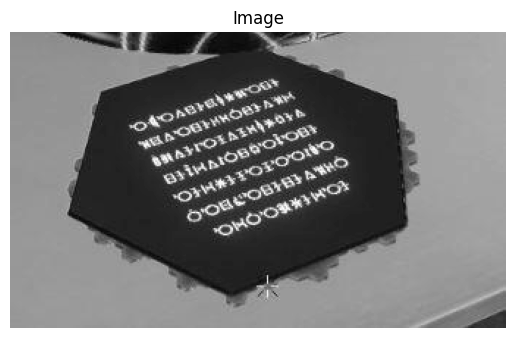

In [28]:
import cv2


# Görüntüyü yükle
image = cv2.imread('tablets\\tablet.jpg')

# Gri tonlamaya çevir
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Görüntüyü özel func ile  ile göster
imshow(gray)




Tabletin kenarlarını tespit etmek 

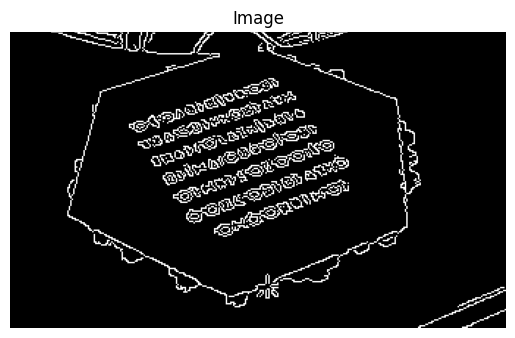

In [31]:
# Kenarları tespit et
edges = cv2.Canny(gray, 100, 200)
imshow(edges)


Hough ile kenarları düzelt ki hesap olayını çözelim

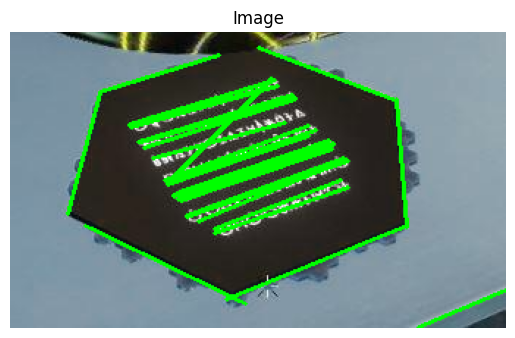

In [42]:
import numpy as np

# Hough dönüşümünü kullanarak çizgileri tespit et
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=10)

if lines is not None:  # Eğer çizgiler varsa
    # Tespit edilen çizgileri görselleştir
    image_with_lines = image.copy()
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

    imshow(image_with_lines)
else:
    print("Çizgiler tespit edilmedi.")
